# **Homework III** - Network Dynamics and Learning
In this homework, you will simulate the pandemic with the goal of learning the network structure characteristics and disease dynamics parameters of the influenza H1N1 pandemic in Sweden in 2009.

In [1]:
import networkx as nx 
import numpy as np 
import scipy as sp
import matplotlib.pyplot as plt 
from itertools import product

## **1) Preliminary parts**
Two preliminary parts: 
- first one will involve simulating an epidemic on a given graph
- second one will be to generate a random graph with preferential attachment

### 1.1 Epidemic on a known graph
We are asked simulate an epidemic on a symmetric $k$-regular graph $G = (V, E)$, with $|V| = 500$ nodes and $k = 4$. We consider $\beta = 0.3$ and $\rho = 0.7$. With one week being one unit of time, simulate the epidemic for 15 weeks.As initial configuration, we start with 10 infected nodes selected at random from the node set $V$. 

We need to repeat this experiments $N=100$ times, considering:
- average number of newly infected individuals each week
- average total number of susceptible, infected, and recovered individuals at each week

First of all, we need to create the $4$-regular graph $G$.

In [2]:
N = 500 # number of nodes
k = 4 # number of nodes connected for each node

G = nx.Graph()
sources = np.arange(N)

for i in range(1, int(k/2) + 1):
    targets = np.roll(sources, i)
    G.add_edges_from(zip(sources, targets))

Now we need to define the Markov chain by constructing its transition matrix Lambda, which is used to simulate the spread of the epidemic. Since we are dealing with large network ($N=500$), instead of precomputing the transition matrix $\Lambda$, we compute its rows when needed. In particular, when the process is at some configuration $x$, row $x$ of $\Lambda$ is computed and used to compute the probabilities of transitions from $x$ and to pick the next visited configuration. 

In [3]:
# Paramters initialization 
beta = 0.3
rho= 0.7
n_steps = 100 # number of the step of the simulation
n_weeks = 15 # weeks of simulation
initial_I = 10 # initial infected people
n_states = 3 # SIR model

simulations = np.zeros([n_steps,n_weeks, N])

# Simulation loop
for i in range(n_steps):
        
    states = np.zeros([n_weeks, N])
    
    # Initial condition 
    x0 = np.zeros(N)
    
    # randomly choose 10 initial infected
    idx = np.random.choice(list(G.nodes), size=initial_I)
    for j in idx:
        x0[j] = 1
        
    # Save initial states for each node
    states[0] = x0
    
    for j in range(1,n_weeks):
        # Take last configuration
        x = np.copy( states[j-1] )        
        
        rates = np.zeros([N,n_states])
    
        for agent in range(N) :
            if x[agent] == 0:
                m=0
                for neig in dict(G.adj[agent]).keys() :
                    if x[neig] == 1:
                        m+=1
            else: 
                m=0
                
            if x[agent] == 0 :
                rates[agent] = np.array([(1-beta)**m,  1 - (1-beta)**m, 0])
    
            if x[agent] == 1 :
                rates[agent] = np.array([0,  1-rho, rho])
    
            elif x[agent] == 2:
                rates[agent] = np.array([0, 0, 1])
    
        
        # Chose the next configuration 
        next_pos = np.argmax(np.cumsum(rates,axis=1) > np.random.rand(N,1), axis=1)
        states[j] = next_pos
        
    simulations[i] = states

Now we need to find the average of the newly infected individuals each week

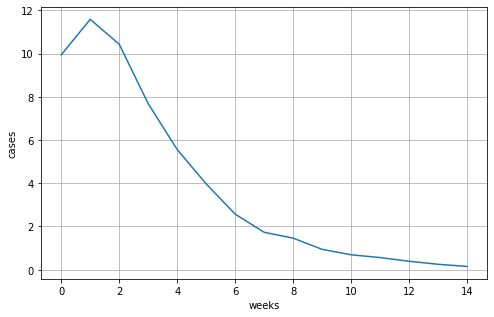

In [4]:
simulation_week_i = np.zeros([n_steps, n_weeks])

for i in range(simulations.shape[0]):
    
    cases_i = np.zeros(simulations[i].shape[0])
    
    for case in range(simulations[i].shape[0]):
        
        states = case
        
        if case == 0:
            cases_i[case] = int(np.argwhere(simulations[i, case] == 1).shape[0])
        else:
            cases_i[case] = int(np.argwhere(((simulations[i, case]==1) & (simulations[i,case-1]<simulations[i,case]) ) ).shape[0]) 
    
    simulation_week_i[i] =  cases_i
    
avg_x_week = np.mean(simulation_week_i ,axis=0)

plt.figure(figsize = (8 ,5))
plt.plot(range(n_weeks), avg_x_week) 
plt.xlabel("weeks")
plt.ylabel("cases")
plt.grid()
plt.savefig("images/1-1.png", dpi=300, bbox_inches='tight')
plt.show()

Now we need to find how many individuals in total that are susceptible/infected/recovered at each week (on the average).

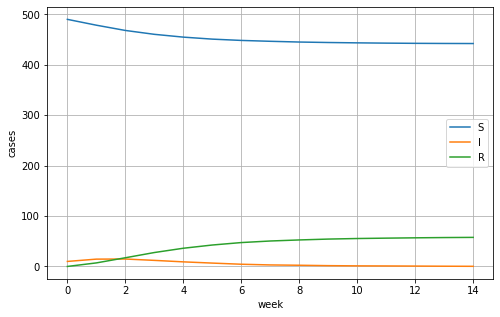

In [5]:
total_SIR = np.zeros([n_weeks, n_states])

for simulation in simulations :
    total_x_simulation = np.zeros([simulation.shape[0],n_states])
    
    for i in range(simulation.shape[0]):
        for j in range(n_states):
            total_x_simulation[i,j] = int(np.argwhere(simulation[i] == j).shape[0])
    
    total_SIR = total_SIR + total_x_simulation
    
avg_SIR = total_SIR / n_steps

plt.figure(figsize = (8 ,5))
plt.plot(range(n_weeks), avg_SIR[:,0], label = "S") 
plt.plot(range(n_weeks), avg_SIR[:,1], label = "I") 
plt.plot(range(n_weeks), avg_SIR[:,2], label = "R")
plt.xlabel("week")
plt.ylabel("cases")
plt.legend()
plt.grid()
plt.savefig("images/1-2.png", dpi=300, bbox_inches='tight')
plt.show()

### 1.2 Generate random graph
We are asked to generate a random graph of a large size (at least 900 nodes) with average degree $k \in Z^+$, given an initial graph $G_1 = (V_1, E_1)$ that's a complete graph with $|V_1| = k_0 = k+1$ nodes

In [6]:
k = 4
random_G = nx.generators.classic.complete_graph(k + 1)

for i in range(k+1, 900):
    
    w = np.array(random_G.degree)[:,1]
    prob = w / np.sum(w) 
    c = (k + (i % 2)) // 2

    idx = np.random.choice(random_G.nodes(), size=c, replace=False, p=prob)
    random_G.add_node(i)
    
    for link in range(c):
        random_G.add_edge(i, idx[link]) 

print("Average degree =",np.mean(np.array(random_G.degree)[:,1]))

Average degree = 4.0


As we can see we can change the average degreee by only changing the value of $k$.

## **2) Simulate a pandemic without vaccination**

In this second exercise, we are asked to simulate once again the spread of the pandemic, as  in exercise 1.1, but this time considering the random graph generate in point 1.2. 

First of all, we  need to generate a random graph $G = (V, E)$ with $|V|=500$ nodes, with average degree $k = 6$.

In [7]:
N = 500
k = 6

random_G = nx.generators.classic.complete_graph(k + 1)

for i in range(k+1, N):
    
    w = np.array(random_G.degree)[:,1]
    prob = w / np.sum(w) 
    c = (k + (i % 2)) // 2

    idx = np.random.choice(random_G.nodes(), size=c, replace=False, p=prob)
    random_G.add_node(i)
    
    for link in range(c):
        random_G.add_edge(i, idx[link]) 

Then, we need to simulate the pandemic for 15 weeks (one week being one unit of time) on $G$, with $\beta = 0.3$ and $\rho = 0.7$, and 10 initial infected people (same identical simulation loop).

In [8]:
# Parameters initialization 
beta = 0.3
rho= 0.7
n_steps = 100 # number of the step of the simulation
n_weeks = 15 # weeks of simulation
initial_I = 10 # initial infected people
n_states = 3 # SIR model

simulations = np.zeros([n_steps,n_weeks, N])

# Simulation loop
for i in range(n_steps):
        
    states = np.zeros([n_weeks, N])
    
    # Initial condition 
    x0 = np.zeros(N)
    
    # randomly choose 10 initial infected
    idx = np.random.choice(list(random_G.nodes), size=initial_I)  
    for j in idx:
        x0[j] = 1
        
    # Save initial states for each node
    states[0] = x0
    
    for j in range(1,n_weeks):
        # Take last configuration
        x = np.copy( states[j-1] )        
        
        rates = np.zeros([N,n_states])
    
        for agent in range(N) :
            if x[agent] == 0:
                m=0
                for neig in dict(random_G.adj[agent]).keys() :
                    if x[neig] == 1:
                        m+=1
            else:
                m=0
                
            if x[agent] == 0 :
                rates[agent] = np.array([(1-beta)**m,  1 - (1-beta)**m, 0])
    
            if x[agent] == 1 :
                rates[agent] = np.array([0,  1-rho, rho])
    
            elif x[agent] == 2:
                rates[agent] = np.array([0, 0, 1])
    
        
        # Chose the next configuration 
        next_pos = np.argmax(np.cumsum(rates,axis=1) > np.random.rand(N,1), axis=1)
        states[j] = next_pos
        
    simulations[i] = states

Once again, as before, we are asked to find the average number of newly infected people each week.

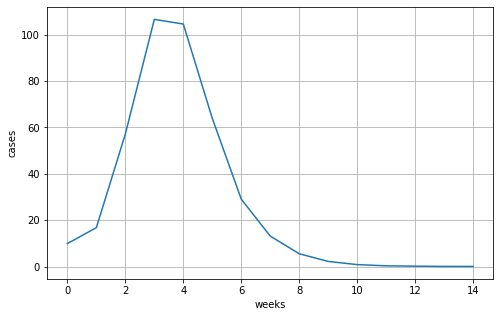

In [9]:
simulation_week_i = np.zeros([n_steps, n_weeks])

for i in range(simulations.shape[0]):
    
    cases_i = np.zeros(simulations[i].shape[0])
    
    for case in range(simulations[i].shape[0]):
                
        if case == 0:
            cases_i[case] = int(np.argwhere(simulations[i, case] == 1).shape[0])
        
        else:
            cases_i[case] = int(np.argwhere(((simulations[i, case]==1) & (simulations[i,case-1]<simulations[i,case]) ) ).shape[0]) 
    
    simulation_week_i[i] =  cases_i
    
avg_x_week = np.mean(simulation_week_i ,axis=0)

plt.figure(figsize = (8,5))
plt.plot(range(n_weeks), avg_x_week) 
plt.xlabel("weeks")
plt.ylabel("cases")
plt.grid()
plt.savefig("images/2-1.png", dpi=300, bbox_inches='tight')
plt.show()

And again, how many individuals in total that are susceptible/infected/recovered at each week (on the average).

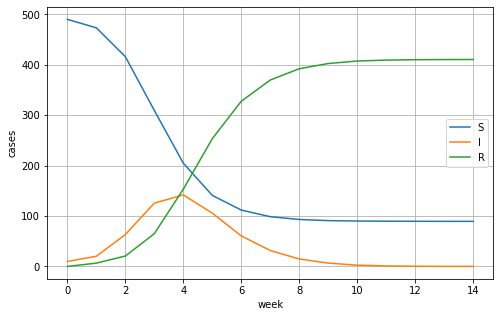

In [10]:
total_SIR = np.zeros([n_weeks, n_states])

for simulation in simulations :
    total_x_simulation = np.zeros([simulation.shape[0],n_states])
    
    for i in range(simulation.shape[0]):
        for j in range(n_states):
            total_x_simulation[i,j] = int(np.argwhere(simulation[i] == j).shape[0])
    
    total_SIR = total_SIR + total_x_simulation
    
avg_SIR = total_SIR / n_steps

plt.figure(figsize = (8 ,5))
plt.plot(range(n_weeks), avg_SIR[:,0], label = "S") 
plt.plot(range(n_weeks), avg_SIR[:,1], label = "I") 
plt.plot(range(n_weeks), avg_SIR[:,2], label = "R")
plt.xlabel("week")
plt.ylabel("cases")
plt.legend()
plt.grid()
plt.savefig("images/2-2.png", dpi=300, bbox_inches='tight')
plt.show()

## **3) Simulate a pandemic with vaccination**

In this third exercise, we are asked to simulate the pandemic as before, but now taking into account vaccination effect: in particular, during each week, some parts of the population will receive vaccination (once a person is vaccinated it cannot be infected). We assume that, regardless of the state of an individual prior to the vaccination, once vaccinated the individual will not be able to become infected nor infect any other individuals.

Once again, we need to generate a random graph $G = (V, E)$ with $|V| = 500$ nodes, average degree $k=6$.

In [11]:
N = 500
k = 6

random_G = nx.generators.classic.complete_graph(k + 1)

for i in range(k+1, N):
    
    w = np.array(random_G.degree)[:,1]
    prob = w / np.sum(w) 
    c = (k + (i % 2)) // 2

    idx = np.random.choice(random_G.nodes(), size=c, replace=False, p=prob)
    random_G.add_node(i)
    
    for link in range(c):
        random_G.add_edge(i, idx[link]) 

We need to simulation the pandemic for 15 weeks (one week being one unit of time) on $G$, with $\beta = 0.3$ and $\rho = 0.7$, and 10 initial infected people. However, this time we need to use the following vaccination scheme:
\begin{equation}
    \text{Vacc}(t) = [0,5,15,25,35,45,55,60,60,60,60,60,60,60,60]
\end{equation}

In [12]:
# Paramters initialization 
beta = 0.3
rho= 0.7
n_steps = 100 # number of the step of the simulation
n_weeks = 15 # weeks of simulation
initial_I = 10 # initial infected people
n_states = 4 # SIR + Vaccinated model
vax_scheme = [0,5,15,25,35,45,55,60,60,60,60,60,60,60,60]

simulations = np.zeros([n_steps, n_weeks, N])

# Simulation loop considering vaccination
for i in range(n_steps):
    # ------------- INITIALIZATION PHASE -------------
    states = np.zeros([n_weeks, N])

    # Initial condition 
    x0 = np.zeros(N)
    
    # randomly choose 10 initial infected
    idx = np.random.choice(list(random_G.nodes), size=initial_I)
    for j in idx:
        x0[j] = 1
        
    # Save initial states for each node
    states[0] = x0
    
    for j in range(1,n_weeks):
        # ------------- VACCINATION PHASE -------------
        # vaccinated during this week
        vax_in_this_week = vax_scheme[j] - vax_scheme[j-1]
            
        # find the first eligible to be vaccinated
        states_of_week = np.copy(states[j-1])
        first_sir = np.where(states_of_week < 3)[0]
        
        # people that are to be vaccinated in this week (rounded to the nearest integer)
        total_to_be_vax = round((N*vax_in_this_week)/100)
        idx_to_be_vax = np.random.choice(first_sir, size=total_to_be_vax, replace=False)
        
        # define the new state (that considers vaccinated people)
        for idx in idx_to_be_vax:
            states_of_week[idx] = 3
        
        # consider the new state with the vaccinated in this week 
        x = np.copy(states_of_week)        
        
        # ------------- PANDEMIC SIMULATION PHASE -------------
        rates = np.zeros([N, n_states])
    
        for agent in range(N) :
            if x[agent] == 0:
                m=0
                for neig in dict(random_G.adj[agent]).keys() :
                    if x[neig] == 1:
                        m+=1
            else:
                m = 0
        
            if x[agent] == 0:
                rates[agent] = np.array([(1-beta)**m,  1 - (1-beta)**m, 0, 0])
    
            elif x[agent] == 1 :
                rates[agent] = np.array([0,  1-rho, rho, 0])
    
            elif x[agent] == 2:
                rates[agent] = np.array([0, 0, 1, 0])
                
            elif x[agent] == 3:
                rates[agent] = np.array([0, 0, 0, 1])
            
        
        # Chose the next configuration 
        next_pos = np.argmax(np.cumsum(rates,axis=1) > np.random.rand(N,1), axis=1)
        states[j] = next_pos
        
    simulations[i] = states

In this case, we are asked to find and plot the average number of newly infected and newly vaccinated individuals for each week.

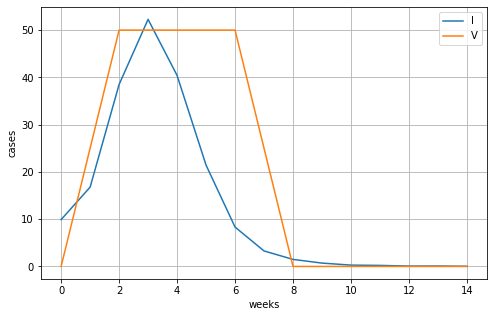

In [13]:
simulation_week_i = np.zeros([n_steps, n_weeks])
simulation_week_v = np.zeros([n_steps, n_weeks])

for i in range(simulations.shape[0]):
    
    cases_i = np.zeros(simulations[i].shape[0])
    cases_v = np.zeros(simulations[i].shape[0])
    
    for case in range(simulations[i].shape[0]):
                
        if case == 0:
            cases_i[case] = int(np.argwhere(simulations[i, case] == 1).shape[0])
            cases_v[case] = int(np.argwhere(simulations[i, case] == 3).shape[0])
            
        else:
            cases_i[case] = int(np.argwhere(((simulations[i, case]==1) & (simulations[i,case-1]<simulations[i,case]))).shape[0])
            cases_v[case] = int(np.argwhere(((simulations[i, case]==3) & (simulations[i,case-1]<simulations[i,case]))).shape[0])
            
    
    simulation_week_i[i] =  cases_i
    simulation_week_v[i] =  cases_v
    
avg_x_week_i = np.mean(simulation_week_i ,axis=0)
avg_x_week_v = np.mean(simulation_week_v ,axis=0)

plt.figure(figsize = (8,5))
plt.plot(range(n_weeks), avg_x_week_i, label = "I") 
plt.plot(range(n_weeks), avg_x_week_v, label = "V") 
plt.xlabel("weeks")
plt.ylabel("cases")
plt.legend()
plt.grid()
plt.savefig("images/3-1.png", dpi=300, bbox_inches='tight')
plt.show()

And finally, the average total number of susceptible, infected, recovered and vaccinated individuals at each week.

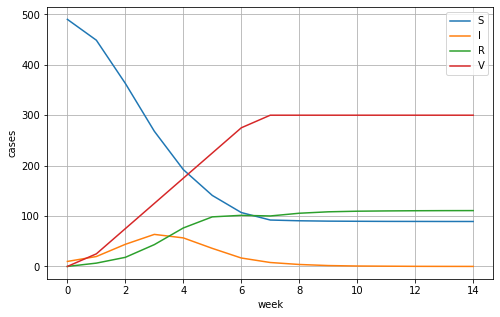

In [14]:
total_SIR = np.zeros([n_weeks, n_states])

for simulation in simulations :
    total_x_simulation = np.zeros([simulation.shape[0],n_states])
    
    for i in range(simulation.shape[0]):
        for j in range(n_states):
            total_x_simulation[i,j] = int(np.argwhere(simulation[i] == j).shape[0])
    
    total_SIR = total_SIR + total_x_simulation
    
avg_SIR = total_SIR / n_steps

plt.figure(figsize = (8 ,5))
plt.plot(range(n_weeks), avg_SIR[:,0], label = "S") 
plt.plot(range(n_weeks), avg_SIR[:,1], label = "I") 
plt.plot(range(n_weeks), avg_SIR[:,2], label = "R")
plt.plot(range(n_weeks), avg_SIR[:,3], label = "V")
plt.xlabel("week")
plt.ylabel("cases")
plt.legend()
plt.grid()
plt.savefig("images/3-2.png", dpi=300, bbox_inches='tight')
plt.show()

## **4) The H1N1 pandemic in Sweden 2009**
In this fourth exercise, we exploit all the previous parts in order to estimate the social structure of the Swedish population and the disease-spread parameters during the H1N1 pandemic. We will simulate the pandemic between week 42, 2009 and week 5, 2010. During these weeks, the fraction of population that had received vaccination was:
\begin{equation}
\text{Vacc}(t) = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
\end{equation}
To reduce simulation time, we will scale down the population of Sweden to $n = |V| = 934$. For the scaled version, the number of newly infected individuals each week in the period between week 42, 2009 and week 5, 2010 was:
\begin{equation}
I_0(t) = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
\end{equation}
The following algorithm will do a gradient-based search over the parameter space of $k$, $\beta$, and $\rho$ in order to find the set of parameters that best matches the real pandemic.

Since this algorithm requires, for each set of paramters ($k, \beta, \rho$), multiple repetitive and redundant steps, we define some function in order to lighten the pipeline.

### 1) Function to generate a random graph
We firstly define a function to generate a random graph using the preferential attachment.

In [8]:
def generate_random_graph(k, n):
    
    np.random.seed(0)    
    random_G = nx.generators.classic.complete_graph(k + 1)

    for i in range(k+1, n):
    
        w = np.array(random_G.degree)[:,1]
        prob = w / np.sum(w) 
        c = (k + (i % 2)) // 2

        idx = np.random.choice(random_G.nodes(), size=c, replace=False, p=prob)
        random_G.add_node(i)
    
        for link in range(c):
            random_G.add_edge(i, idx[link]) 

    return random_G

### 2) Function to simulate the pandemic
We then define a function to simulate the pandemic, using the method aleready developed in section 3 ("Simulate pandemic with vaccination").

In [9]:
def simulate_pandemic(random_G, beta, rho, n_steps, n_weeks, initial_I, n_states, vax_scheme):
    
    N = len(random_G)
    simulations = np.zeros([n_steps, n_weeks, N])

    # Simulation loop considering vaccination
    for i in range(n_steps):
        # ------------- INITIALIZATION PHASE -------------
        states = np.zeros([n_weeks, N])
        # Initial condition 
        x0 = np.zeros([N])
        # randomly choose "initial_I" infected
        idx = np.random.choice(list(random_G.nodes), size=initial_I)
        for j in idx:
            x0[j] = 1
           
        # ------------- FIRST ROUND OF VACCINATION -------------
        # In this case we have 5% already at step 0       
        first_sir = np.where(x0 < 3 )[0]
        total_to_be_vax = round((N*vax_scheme[0])/100)
        idx_to_be_vax = np.random.choice(first_sir, size=total_to_be_vax, replace=False)

        # define the new state (that considers vaccinated people)
        for idx in idx_to_be_vax:
            x0[idx] = 3
    
        # Save initial states for each node
        states[0] = x0
        
        for j in range(1,n_weeks):
            # ------------- FURTHER VACCINATION PHASESCannot take a larger sample than population when 'replace=False' -------------
            # vaccinated during this week
            vax_in_this_week = vax_scheme[j] - vax_scheme[j-1]

            # find the first eligble to be vaccinated
            states_current_week = np.copy(states[j-1])
            first_sir = np.where(states_current_week < 3)[0]

            # people that are to be vaccinated in this week (rounded to the nearest integer)
            total_to_be_vax = round((N*vax_in_this_week)/100)
            idx_to_be_vax = np.random.choice(first_sir, size=total_to_be_vax, replace=False)

            # define the new state (that considers vaccinated people)
            for idx in idx_to_be_vax:
                states_current_week[idx] = 3

            # consider the new state with the vaccinated in this week 
            x = np.copy(states_current_week)        
            
            # ------------- PANDEMIC SIMULATION PHASE -------------
            rates = np.zeros([N, n_states])

            for agent in range(N) :
                if x[agent] == 0:
                    m=0
                    for neig in dict(random_G.adj[agent]).keys():
                        if x[neig] == 1:
                            m+=1
                else:
                    m = 0

                if x[agent] == 0:
                    rates[agent] = np.array([(1-beta)**m,  1 - (1-beta)**m, 0, 0])

                elif x[agent] == 1 :
                    rates[agent] = np.array([0,  1-rho, rho, 0])

                elif x[agent] == 2:
                    rates[agent] = np.array([0, 0, 1, 0])

                elif x[agent] == 3:
                    rates[agent] = np.array([0, 0, 0, 1])


            # Chose the next configuration 
            next_pos = np.argmax(np.cumsum(rates,axis=1) > np.random.rand(N,1), axis=1)
            states[j] = next_pos

        simulations[i] = states
    
    return simulations

## 3) Function to search best configuration of $(k, \beta, \rho)$
Finally, we can define the function that will exploit the previous ones to carry out the algorithm for the search of the best configuration of the parameter. Basically, the algorithm, starting from an initial guess for the parameters $(k_0, \beta_0, \rho_0)$, follows these steps:
1. for each set of parameter $(k, \beta, \rho)$ in the parameter-space:
    - gnerate a random graph, using the `generate_random_graph()` function;
    - simulate the pandemic, with the `simulate_pandemic()` function;
    - compute the root-mean-square error (RMSE) as:
    \begin{equation}
    \text{RMSE} = \sqrt{\frac{1}{15}\sum_{t=1}^{15}(I(t)-I_0(t))^2}
    \end{equation}
    where $I(t)$ is the average number of newly infected individuals each week in the simulation and $I_0(t)$ is the true value of newly infected individuals each week.
2. Update $k_0 , \beta_0, \rho_0$ to the set of parameters yielding the lowest RMSE. We stop when these do not improve from the previous step.

In [10]:
def search_algorithm(pandemic, params):
    
    # Neighborhood generation
    k = [params["k"]-params["delta_k"], params["k"], params["k"]+params["delta_k"]]
    beta = [params["beta"]-params["delta_beta"], params["beta"], params["beta"]+params["delta_beta"]]
    rho= [params["rho"]-params["delta_rho"], params["rho"], params["rho"]+params["delta_rho"]]
        
    combinations = list(product(k, beta, rho))    
    results = []
    
    # Neighborhood loop 
    for combination in combinations:
        
        # Graph Generation
        G = generate_random_graph(combination[0], pandemic["N"])
        
        # Pandemic simulation
        simulations = simulate_pandemic(G, combination[1], combination[2],pandemic["n_steps"], 
                                        pandemic["n_weeks"], pandemic["I0"][0],
                                        pandemic["n_states"], pandemic["vax_scheme"])
        
        # Compute the average number of newly infected individuals each week      
        simulation_week_i = np.zeros([pandemic["n_steps"], pandemic["n_weeks"]])

        for i in range(simulations.shape[0]):

            cases_i = np.zeros(simulations[i].shape[0])

            for case in range(simulations[i].shape[0]):

                if case == 0:
                    cases_i[case] = int(np.argwhere(simulations[i,case] == 1).shape[0])

                else:
                    cases_i[case] = int(np.argwhere(((simulations[i, case]==1) & (simulations[i, case-1]<simulations[i,case]))).shape[0]) 

            simulation_week_i[i] =  cases_i

        avg_x_week = np.mean(simulation_week_i, axis=0)
        
        # Compute RMSE 
        rmse = np.sqrt((np.sum((avg_x_week[1:] - pandemic["I0"][1:])**2))/15)
        results.append(rmse)
        

    # Chose the parameters that minimize the RMSE
    results = np.array(results)
    best_index = np.argmin(results)
    best_combination = combinations[best_index]
    
    return best_combination[0], best_combination[1], best_combination[2], results[best_index]

Now that we have defined the different functions, we can exploit the algorithm to estimate the average degree $k$ and the disease-spread parameters $\beta$ and $\rho$ for the pandemic.

First of all, we define the parameters for our simulation.

In [18]:
# Parameters for the pandemic spread
pandemic = {
    "I0": [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0],
    "N": 934,
    "vax_scheme": [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60], 
    "n_steps": 10,
    "n_weeks": 16,
    "n_states": 4
}
# Parameters to search
params = {
    "k": 10, "beta": 0.3, "rho": 0.6, 
    "delta_k": 1, "delta_beta": 0.1, "delta_rho": 0.1,
}

And now we can start of search loop

In [19]:
best_parameters = [params["k"], params["beta"], params["rho"]]

lowest_rmse = np.inf

# Loop of deltas reduction search
while True : 
    last_rmse = np.inf
    
    k, beta, rho = best_parameters[0],  best_parameters[1],  best_parameters[2]
    
    # Loop of around search
    while True  :
        params["k"], params["beta"], params["rho"], current_rmse = search_algorithm(pandemic, params)
    
        print("(k, beta, rho)=({:.3f}, {:.3f}, {:.3f}) with rmse:{:.3f}".format(k, beta, rho, current_rmse))
    
        # If no better solution find go on
        if np.round(current_rmse, 2) >= np.round(last_rmse, 2):
            break
    
        last_rmse = current_rmse
        local_best_parameters = [params["k"], params["beta"],params["rho"]]
        
    # If no better solution found halve the deltasa
    if np.round(current_rmse, 2) >= np.round(lowest_rmse, 2):
        break
    
    params["delta_k"] = round(params["delta_k"]/2)
    params["delta_beta"] = params["delta_beta"]/2
    params["delta_rho"]= params["delta_rho"]/2
    
    print("Deltas updated!")
    
    lowest_rmse = last_rmse
    global_best_parameters = local_best_parameters
    
print("BEST (k, beta, rho)={:.3f} with rmse: {:.3f}]".format(global_best_parameters[0], global_best_parameters[1], global_best_parameters[2], lowest_rmse))

(k, beta, rho) = (9.000, 0.200, 0.500) with rmse:5.022
(k, beta, rho) = (9.000, 0.200, 0.600) with rmse:5.675
(k, beta, rho) = (9.000, 0.200, 0.700) with rmse:6.138
(k, beta, rho) = (9.000, 0.300, 0.500) with rmse:18.171
(k, beta, rho) = (9.000, 0.300, 0.600) with rmse:16.572
(k, beta, rho) = (9.000, 0.300, 0.700) with rmse:16.156
(k, beta, rho) = (9.000, 0.400, 0.500) with rmse:43.054
(k, beta, rho) = (9.000, 0.400, 0.600) with rmse:41.749
(k, beta, rho) = (9.000, 0.400, 0.700) with rmse:40.974
(k, beta, rho) = (10.000, 0.200, 0.500) with rmse:8.523
(k, beta, rho) = (10.000, 0.200, 0.600) with rmse:8.650
(k, beta, rho) = (10.000, 0.200, 0.700) with rmse:9.024
(k, beta, rho) = (10.000, 0.300, 0.500) with rmse:24.936
(k, beta, rho) = (10.000, 0.300, 0.600) with rmse:24.178
(k, beta, rho) = (10.000, 0.300, 0.700) with rmse:23.473
(k, beta, rho) = (10.000, 0.400, 0.500) with rmse:34.711
(k, beta, rho) = (10.000, 0.400, 0.600) with rmse:34.126
(k, beta, rho) = (10.000, 0.400, 0.700) with r

Now that the simulation has found the best configuration of $(k, \beta, \rho)$, we can run the best simulation of the H1N1 pandemic in Sweden 2009. Specifically:
1. initialize our best configuration of parameters;
2. generate a new random graph with the best k we found;
3. simulate our pandemic once again, for 15 weeks, considering 100 iterations to have more stable results.

In [20]:
# 1) Best paramters (k, beta, rho)
best_k_beta_rho = [global_best_parameters[0], global_best_parameters[1], global_best_parameters[2]]
#best_k_beta_rho = global_best_parameters
print("Our best parameters (k, beta, rho)=", best_k_beta_rho)

# 2) Generate a new random graph with the new k 
random_G = generate_random_graph(best_k_beta_rho[0], pandemic["N"])

# 3) Our best simulation
# Increase number of steps to have more stable results
pandemic["n_steps"] = 100

# Simulation loop
simulations = simulate_pandemic(random_G, best_k_beta_rho[1], best_k_beta_rho[2], 
                                pandemic["n_steps"], pandemic["n_weeks"],
                                pandemic["I0"][0], pandemic["n_states"], pandemic["vax_scheme"])

Our best parameters (k, beta, rho)= [9, 0.21406249999999996, 0.5546875]


Now that we have run this simulation, we can plot the average number of newly infected individuals each week according to the model (with your best parameters) compared to the true value of newly infected individuals each week.

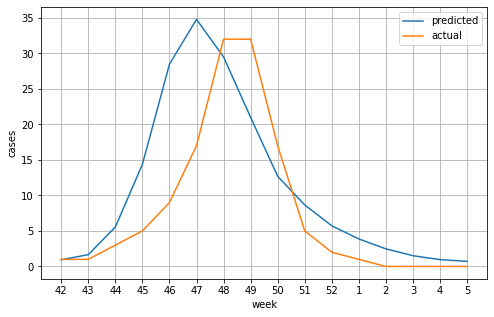

In [21]:
simulation_week_i = np.zeros([pandemic["n_steps"], pandemic["n_weeks"]])

for i in range(simulations.shape[0]):
    
    cases_i = np.zeros(simulations[i].shape[0])
    
    for case in range(simulations[i].shape[0]):
                
        if case == 0:
            cases_i[case] = int(np.argwhere(simulations[i, case] == 1).shape[0])
        
        else:
            cases_i[case] = int(np.argwhere(((simulations[i, case]==1) & (simulations[i,case-1]<simulations[i,case]) ) ).shape[0]) 
    
    simulation_week_i[i] =  cases_i
    
avg_x_week = np.mean(simulation_week_i ,axis=0)

plt.figure(figsize = (8 ,5))
plt.plot(range(pandemic["n_weeks"]), avg_x_week, label="predicted") 
plt.plot(range(pandemic["n_weeks"]), pandemic["I0"], label = "actual") 
plt.xlabel("week")
plt.ylabel("cases")
plt.grid()
weeks_plot = [x for x in range(42, 53)] + [x for x in range(1,6)]
plt.xticks(range(pandemic["n_weeks"]), weeks_plot)
plt.legend()
plt.savefig("images/4-1.png", dpi=300, bbox_inches='tight')
plt.show()

And finally we can, once again, plot the average total number of susceptible, infected, recovered and vaccinated individuals at each week for the H1N1 pandemic simulation.

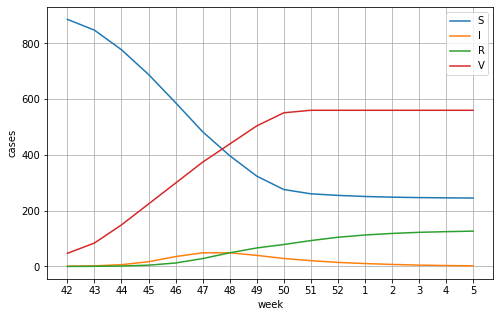

In [22]:
total_SIR = np.zeros([pandemic["n_weeks"], pandemic["n_states"]])

for simulation in simulations :
    total_x_simulation = np.zeros([simulation.shape[0],pandemic["n_states"]])
    
    for i in range(simulation.shape[0]):
        for j in range(pandemic["n_states"]):
            total_x_simulation[i,j] = int(np.argwhere(simulation[i] == j).shape[0])
    
    total_SIR = total_SIR + total_x_simulation
    
avg_SIR = total_SIR / pandemic["n_steps"]

plt.figure(figsize = (8 ,5))
plt.plot(range(pandemic["n_weeks"]), avg_SIR[:,0], label = "S") 
plt.plot(range(pandemic["n_weeks"]), avg_SIR[:,1], label = "I") 
plt.plot(range(pandemic["n_weeks"]), avg_SIR[:,2], label = "R")
plt.plot(range(pandemic["n_weeks"]), avg_SIR[:,3], label = "V")
plt.xlabel("week")
plt.ylabel("cases")
weeks_plot = [x for x in range(42, 53)] + [x for x in range(1,6)]
plt.xticks(range(pandemic["n_weeks"]), weeks_plot)
plt.legend()
plt.grid()
plt.savefig("images/4-2.png", dpi=300, bbox_inches='tight')
plt.show()

## **5) Challenge**
In this last exercise we try to find a better random graph (i.e. one that does not use preferential attachment) to represent the network for the pandemic. We will try to also find a better algorithm to estimate the parameters with respect to the one proposed in Exercise 4.

### 5.1) A better algorithm for the search
First of all, we will try to exploit the tabu search to employ a better algorithm to find our best parameters to estimate our pandemic. 

In [2]:
# Function to define the neighbourhood for each paramter
def neighbors(temp):
    
    k = temp[0]
    neigh_k = [k - 1, k - 2, k, k + 1, k + 2]
    
    beta = temp[1]
    neigh_beta = [np.round(beta,3),
                  np.round(beta - 0.01, 3), np.round(beta + 0.01, 3),
                  np.round(beta - 0.05, 3), np.round(beta + 0.05, 3),
                  np.round(beta - 0.1,  3),  np.round(beta + 0.1, 3),
                 ]
    rho = temp[2]
    neigh_rho = [np.round(rho, 3), 
                 np.round(rho - 0.01, 3), np.round(rho + 0.01, 3),
                 np.round(rho - 0.05, 3), np.round(rho + 0.05, 3),
                 np.round(rho - 0.1, 3),  np.round(rho + 0.1, 3)
                ]
    
    combinations = list(product(neigh_k, neigh_beta, neigh_rho))   
    combinations.remove((k, np.round(beta, 3), np.round(rho, 3)))
    
    return combinations

In [3]:
def tabu_search(combinations, pandemic, graph):
     
    results = []
    
    # Neighborhood loop 
    for combination in combinations:
        
        if combination[0]<= 1 : 
            continue

        if combination[1] <= 0 or combination[1] >= 1 :
            continue
            
        if combination[2] <= 0 or combination[2] >= 1 :
            continue
        
        # Graph Generation
        if graph == "pam":
            G = generate_random_graph(combination[0], pandemic["N"])
        elif graph == "sw" :
            G = nx.newman_watts_strogatz_graph(pandemic["N"], combination[0], p=0.5, seed=100)
        
        
        # Pandemic simulation
        simulations = simulate_pandemic(G, combination[1], combination[2],pandemic["n_steps"], 
                                        pandemic["n_weeks"], pandemic["I0"][0],
                                        pandemic["n_states"], pandemic["vax_scheme"])
        
        # Compute the average number of newly infected individuals each week      
        simulation_week_i = np.zeros([pandemic["n_steps"], pandemic["n_weeks"]])

        for i in range(simulations.shape[0]):

            cases_i = np.zeros(simulations[i].shape[0])

            for case in range(simulations[i].shape[0]):

                if case == 0:
                    cases_i[case] = int(np.argwhere(simulations[i,case] == 1).shape[0])

                else:
                    cases_i[case] = int(np.argwhere(((simulations[i, case]==1) & (simulations[i, case-1]<simulations[i,case]))).shape[0]) 

            simulation_week_i[i] =  cases_i

        avg_x_week = np.mean(simulation_week_i, axis=0)
        
        # Compute RMSE 
        rmse = np.sqrt((np.sum((avg_x_week[1:] - pandemic["I0"][1:])**2))/15)
        results.append(rmse)
        

    # Save parameters that minimize the RMSE
    results = np.array(results)
    best_index = np.argmin(results)
    best_combination = combinations[best_index]
    sorted_index = np.argsort(results)
    
    return [best_combination[0], best_combination[1], best_combination[2]], results[best_index], sorted_index

Now that we have defined these alternative functions, we can exploit the algorithm to estimate the average degree $k$ and the disease-spread parameters $\beta$ and $\rho$ for the pandemic.

First of all, we define the new parameters for our simulation.

In [5]:
# Parameters for the pandemic spread
pandemic = {
    "I0": [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0],
    "N": 934,
    "vax_scheme": [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60], 
    "n_steps": 10,
    "n_weeks": 16,
    "n_states": 4
}
# Parameters to search
params = {
    "k0": 10, "beta0": 0.3, "rho0": 0.6, 
    "delta_k": 1, "delta_beta": 0.1, "delta_rho": 0.1,
}

And now we can start of search loop (reduced loop for just 5 times for brevity's sake, we tested also for 20)

In [33]:
initial_combination = [[params["k0"], params["beta0"], params["rho0"]]]
temp_parameters, temp_rmse, _ = tabu_search(initial_combination, pandemic, "pam")
best_parameters, best_rmse = temp_parameters, temp_rmse 

tabu_moves = []
i = 0
print("Starting...")

# Loop for tabu search to find optimal paramters
while i < 5: 
    print("iteration {}...".format(i))
    
    # If the taboo list legth is equal to the maximum one remove the first element
    if len(tabu_moves) == 50 :
        tabu_moves.pop(0)
        
    # Generate the neighbourhood
    neighbourhood = neighbors(temp_parameters)
    
    # Evalute the neighborhood and get the best one with a list of indexes sorted by the RMSE
    temp_parameters, temp_rmse, sorted_index = tabu_search(neighbourhood,  pandemic, "pam")
    
    # If a new rmse is lower than previous best, we found a new "best" solution 
    if temp_rmse < best_rmse: 
        best_parameters, best_rmse = temp_parameters, temp_rmse 
        print("NEW BEST (k, beta, rho)={} with rmse = {:.3f}]".format(best_parameters, best_rmse))
    
    # if no better solution found
    else :
        
        # we consider new parameters configuration
        for i_s in sorted_index:
            temp_parameters = neighbourhood[i_s]
            
            # if it is not among the prohibited ones
            if temp_parameters not in tabu_moves:
                break
                
        # Update the tabu list with the new set of paramaters
        print("Updating tabu moves and moving...")
        tabu_moves.append(temp_parameters)
        print("(k, beta, rho)=({}, {}, {}) tabu".format(temp_parameters[0], temp_parameters[1], temp_parameters[2]))
        
    i += 1

Starting...
iteration 0...
NEW BEST (k, beta, rho)=[9, 0.2, 0.55] with rmse = 4.897]
iteration 1...
NEW BEST (k, beta, rho)=[9, 0.21, 0.55] with rmse = 3.912]
iteration 2...
Updating tabu moves and moving...
(k, beta, rho)=(9, 0.21, 0.54) tabu
iteration 3...
Updating tabu moves and moving...
(k, beta, rho)=(9, 0.21, 0.55) tabu
iteration 4...
Updating tabu moves and moving...
(k, beta, rho)=(9, 0.22, 0.55) tabu


Once again, now that the new simulation has found the best configuration of $(k, \beta, \rho)$, we can run the best simulation of the H1N1 pandemic in Sweden 2009. Specifically:
1. initialize our best configuration of parameters;
2. generate a new random graph with the best k we found;
3. simulate our pandemic once again, for 15 weeks, considering 100 iterations to have more stable results.

In [34]:
# 1) Best paramters (k, beta, rho)
best_k_beta_rho = best_parameters
print("Our best parameters (k, beta, rho) =", best_k_beta_rho)

# 2) Generate a new random graph with the new k 
random_G = generate_random_graph(best_k_beta_rho[0], pandemic["N"])

# 3) Our best simulation
# Increase number of steps to have more stable results
pandemic["n_steps"] = 100

# Simulation loop
simulations = simulate_pandemic(random_G, best_k_beta_rho[1], best_k_beta_rho[2], 
                                pandemic["n_steps"], pandemic["n_weeks"],
                                pandemic["I0"][0], pandemic["n_states"], pandemic["vax_scheme"])

Our best parameters (k, beta, rho) = [9, 0.21, 0.55]


We can plot the average number of newly infected individuals each week according to the model (with your best parameters) compared to the true value of newly infected individuals each week.

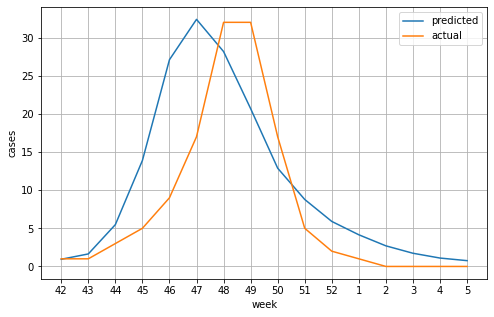

In [35]:
simulation_week_i = np.zeros([pandemic["n_steps"], pandemic["n_weeks"]])

for i in range(simulations.shape[0]):
    
    cases_i = np.zeros(simulations[i].shape[0])
    
    for case in range(simulations[i].shape[0]):
                
        if case == 0:
            cases_i[case] = int(np.argwhere(simulations[i, case] == 1).shape[0])
        
        else:
            cases_i[case] = int(np.argwhere(((simulations[i, case]==1) & (simulations[i,case-1]<simulations[i,case]) ) ).shape[0]) 
    
    simulation_week_i[i] =  cases_i
    
avg_x_week = np.mean(simulation_week_i ,axis=0)

plt.figure(figsize = (8 ,5))
plt.plot(range(pandemic["n_weeks"]), avg_x_week, label="predicted") 
plt.plot(range(pandemic["n_weeks"]), pandemic["I0"], label = "actual") 
plt.xlabel("week")
plt.ylabel("cases")
plt.grid()
weeks_plot = [x for x in range(42, 53)] + [x for x in range(1,6)]
plt.xticks(range(pandemic["n_weeks"]), weeks_plot)
plt.legend()
plt.savefig("images/5-1.png", dpi=300, bbox_inches='tight')
plt.show()

### 5.2) A better random graph
Now that we have foudn a better algorithm, we will define a new method to define a random graph without the preferential attachment of the exercise 4. Notice that, once again, we are trying to represent the network for the pandemic in the most accurate way in order to have the predicted behavior in line with the actual one. 

This method is based on the **Small World** graphic representation offered by `networkx`.

In [11]:
params["k0"] = 10
params["beta0"] = 0.3 
params["rho0"] = 0.6

In [ ]:
initial_combination = [[params["k0"], params["beta0"], params["rho0"]]]
temp_parameters, temp_rmse, _ = tabu_search(initial_combination, pandemic, "pam")
best_parameters, best_rmse = temp_parameters, temp_rmse 

tabu_moves = []
i = 0
print("Starting...")

# Loop for tabu search to find optimal paramters
while i < 5: 
    print("iteration {}...".format(i))
    
    # If the taboo list legth is equal to the maximum one remove the first element
    if len(tabu_moves) == 50 :
        tabu_moves.pop(0)
        
    # Generate the neighbourhood
    neighbourhood = neighbors(temp_parameters)
    
    # Evalute the neighborhood and get the best one with a list of indexes sorted by the RMSE
    temp_parameters, temp_rmse, sorted_index = tabu_search(neighbourhood,  pandemic, "sw")
    
    # If a new rmse is lower than previous best, we found a new "best" solution 
    if temp_rmse < best_rmse: 
        best_parameters, best_rmse = temp_parameters, temp_rmse 
        print("NEW BEST (k, beta, rho)={} with rmse = {:.3f}]".format(best_parameters, best_rmse))
    
    # if no better solution found
    else :
        
        # we consider new parameters configuration
        for i_s in sorted_index:
            temp_parameters = neighbourhood[i_s]
            
            # if it is not among the prohibited ones
            if temp_parameters not in tabu_moves:
                break
                
        # Update the tabu list with the new set of paramaters
        print("Updating tabu moves and moving...")
        tabu_moves.append(temp_parameters)
        print("(k, beta, rho)=({}, {}, {}) tabu".format(temp_parameters[0], temp_parameters[1], temp_parameters[2]))
        
    i += 1

Starting...
iteration 0...
NEW BEST (k, beta, rho)=[8, 0.2, 0.65] with rmse = 7.237]
iteration 1...
NEW BEST (k, beta, rho)=[8, 0.25, 0.7] with rmse = 6.126]
iteration 2...


In [ ]:
# 1) Best paramters (k, beta, rho)
best_k_beta_rho = best_parameters
print("Our best parameters (k, beta, rho) =", best_k_beta_rho)

# 2) Generate a new random graph with the new k 
random_G = nx.newman_watts_strogatz_graph(pandemic["N"], best_k_beta_rho[0], p=0.5, seed = 100)

# 3) Our best simulation
# Increase number of steps to have more stable results
pandemic["n_steps"] = 100

# Simulation loop
simulations = simulate_pandemic(random_G, best_k_beta_rho[1], best_k_beta_rho[2], 
                                pandemic["n_steps"], pandemic["n_weeks"],
                                pandemic["I0"][0], pandemic["n_states"], pandemic["vax_scheme"])

Once again, we plot the average number of newly infected individuals each week according to the model (with your best parameters) compared to the true value of newly infected individuals each week.

In [ ]:
simulation_week_i = np.zeros([pandemic["n_steps"], pandemic["n_weeks"]])

for i in range(simulations.shape[0]):
    
    cases_i = np.zeros(simulations[i].shape[0])
    
    for case in range(simulations[i].shape[0]):
                
        if case == 0:
            cases_i[case] = int(np.argwhere(simulations[i, case] == 1).shape[0])
        
        else:
            cases_i[case] = int(np.argwhere(((simulations[i, case]==1) & (simulations[i,case-1]<simulations[i,case]) ) ).shape[0]) 
    
    simulation_week_i[i] =  cases_i
    
avg_x_week = np.mean(simulation_week_i ,axis=0)

plt.figure(figsize = (8 ,5))
plt.plot(range(pandemic["n_weeks"]), avg_x_week, label="predicted") 
plt.plot(range(pandemic["n_weeks"]), pandemic["I0"], label = "actual") 
plt.xlabel("week")
plt.ylabel("cases")
plt.grid()
weeks_plot = [x for x in range(42, 53)] + [x for x in range(1,6)]
plt.xticks(range(pandemic["n_weeks"]), weeks_plot)
plt.legend()
plt.savefig("images/5-2.png", dpi=300, bbox_inches='tight')
plt.show()